<div style = 'text-align: center;'>
    <img src = '../images/ga_logo_large.png'>
</div>

---
## **App: Ride BigApple** 🚖🍎

---
**Pre Processing and Modeling**

In [1980]:
# import personal library
import importlib.util
import sys

path_to_library = '../scripts/personal_library.py'

# load module
spec = importlib.util.spec_from_file_location('personal_library', path_to_library)
lu = importlib.util.module_from_spec(spec)
sys.modules['personal_library'] = lu
spec.loader.exec_module(lu)

In [2082]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1929]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [1931]:
# maps module
#import googlemaps

# import geodesic module
# from geopy.distance import geodesic

In [1933]:
# read in file
file_path = '../data/clean_data/taxi_clean_set_v2.csv'

taxi = pd.read_csv(file_path, index_col = 'key')
print(taxi.shape)

(53351, 12)


In [871]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance'],
      dtype='object')

Everything looks good and as expected in this clean dataset.

----
### **Modeling and Tracking**

In [1991]:
# list to keep track of metrics
metrics = []

----
**Baseline Model**

First, let's build a baseline model solely based on `geodesic_distance`.  This feature has the highest correlation with `fare_amount`.  Then we'll score the baseline model based on root mean squared error (RMSE) and we'll try to improve on that on every iteration.  This gradual approach usually leads to insightful findings.

In [1957]:
# x matrix
X1 = taxi[['geodesic_distance']]

# y target
y1 = taxi['fare_amount']

# check dimensions
X1.shape, y1.shape

((53351, 1), (53351,))

Because this is a large dataset, every split between training data and test data will follow the default values of 75% to 25% respectively.

In [1960]:
# train/test split, default of 75/25
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 1976)
# check dimensions
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((40013, 1), (13338, 1), (40013,), (13338,))

In [1962]:
# instantiate linear model
lr1 = LinearRegression()

In [1988]:
# fit linear model
lr1.fit(X_train1, y_train1)

LinearRegression()

In [1993]:
metrics.append(lu.model_evaluation(lr1, X_train1, X_test1, y_train1, y_test1))

training r2: 0.812, test r2: 0.822, rmse: 3.894


This is a good start.  The R2 scores are very close to each other, which means this baseline model should generalize well to unseen data. Further, the RMSE is not ourageous, a predicted taxi fare on this model may fluctuate, up or down, by 3.89 dollars.  Not bad overall, but it's still above the actual base fare of 2.50 dollars.

---
**Clustering**

Because the pickup and dropoff coordinates represent geospatial data, this could be use to identify clusters of high rides areas, such as airports, rail hubs, etc.  These clusters may then be useful for engineering features that may help improve the baseline model.  Let's explore.

In [893]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [894]:
# P matrix, for pickup coordinates
# convert coordinates to radians, this is to use geodesic distances
# which are actual distances on earth's surface
# then the metric becomes Haversine distance

P = np.radians(taxi[['pickup_longitude', 'pickup_latitude']].values)
P.shape

(53351, 2)

**Epsilon**<br>
With about 90% of pickups ocurring in Manhattan, let's focus on finding a value for epsilon that is based on the Manhattan grid.<br><br>
Avenues run north-south and viceversa (6th Avenue, 7th Avenue, Broadway, etc.). And streets run east-west/viceversa (57th Street, 34th Street, Houston Street, etc.).  So, we'll call a city block a block from one street to the next, either north or south.  Based on <a href = 'https://gottalovenewyork.com/what-is-the-size-of-manhattan/'>research</a>, the approximate length of a standard city block is about 80 meters, which in degrees (since we're using longitude/latitude data) is approximately 0.00072.<br><br>
A good distance to cluster rides around would range from 1 city block to 5 city blocks.  In meters that would range from 80 meters to 400 meters.  And for the values of epsilon, that would range from  0.00072 degrees to 0.00360 degress.<br><br>
Since this is geographical/spatial data, the metric  for `DBSCAN` must be **Haversine** in order to take into account longitude and latitude coordinates as well as the earth's curvature.

In [898]:
# values of epsilon to try
epsilons = np.linspace(0.00072, 0.00360, 5)

# conversion factor to turn epsilon into radians
radians_conversion = (np.pi / 180)

# mininum number of rides to cluster
minimum_rides = [30, 45, 60]

In [627]:
%%time
# this will be time consuming, let's measure it to have an idea for future iterations

results1 = []

# determine best combination
for eps in epsilons:
    for rides in minimum_rides:
        dbs = DBSCAN(
        # using Haversine distance, so it must be converted to radians
        eps = eps * radians_conversion,         
        # only consider clusters based on certain number of pickups within the search radius                 
        min_samples = rides,
        # use Haversine distance, which measures actual distance over earth's surface
        metric = 'haversine',
        n_jobs = -1)

        dbs.fit(P)
        labels = dbs.labels_

        clusters = len(np.unique(labels[labels != -1]))
    
        silhouette = silhouette_score(P, labels, metric = 'haversine') if clusters > 1 else -1
        
        results1.append(
            {'epsilon': eps, 
             'min_samples': rides, 
             'clusters': clusters, 
             'silhouette_score': silhouette}
        )
    print(f'Epsilon {eps} done.')

Epsilon 0.00072 done.
Epsilon 0.0014399999999999999 done.
Epsilon 0.00216 done.
Epsilon 0.0028799999999999997 done.
Epsilon 0.0036 done.
CPU times: total: 47min 31s
Wall time: 46min 26s


Let's now tabulate and visualize the results.

In [1995]:
summary_table = pd.DataFrame(results1)
summary_table

,epsilon,min_samples,clusters,silhouette_score
0,0.00072,30,16,-0.470738
1,0.00072,45,17,-0.431408
2,0.00072,60,21,-0.493909
3,0.00144,30,11,-0.038394
4,0.00144,45,11,-0.082117
5,0.00144,60,7,0.251721
6,0.00216,30,10,0.088988
7,0.00216,45,8,-0.045404
8,0.00216,60,5,-0.024897
9,0.00288,30,9,0.256899


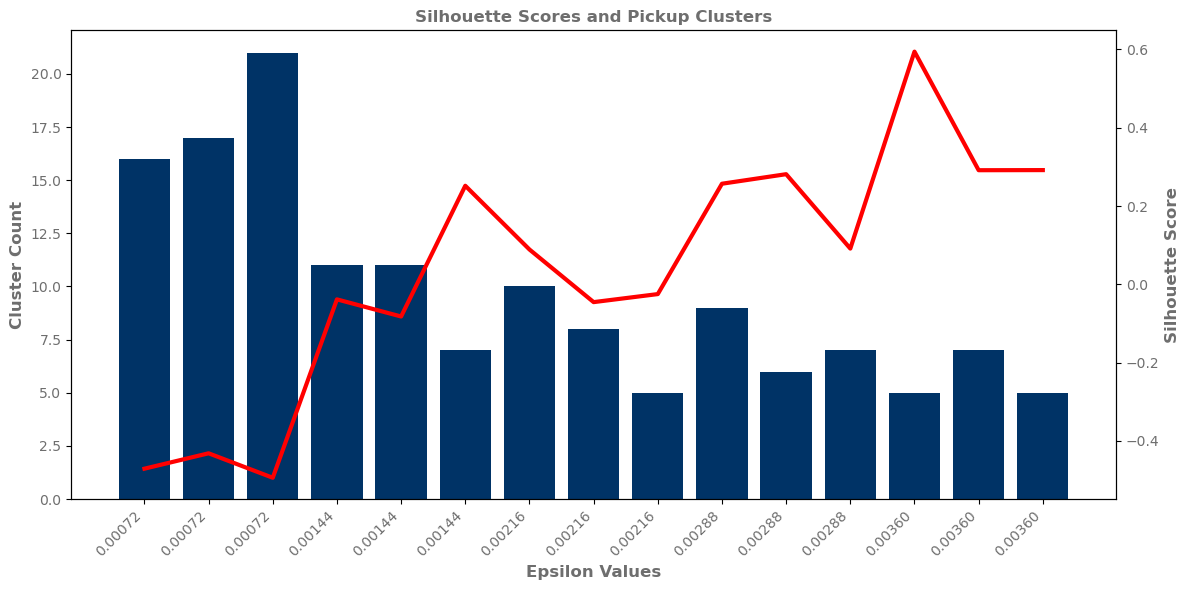

In [2197]:
# plot silhouette scores and clusters

fig, ax1 = plt.subplots(figsize = (12, 6))

ax1.bar(summary_table.index, summary_table['clusters'], color = '#003366', label = 'Clusters')
ax1.set_xlabel('Epsilon Values', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax1.set_ylabel('Cluster Count', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax1.tick_params(axis = 'both', labelcolor = '#6e6e6e')
epsilon_values = summary_table['epsilon'].values

# used chatgpt for these two lines------------------------------------------------------------------------
ax1.set_xticks(range(len(epsilon_values)))
ax1.set_xticklabels([f"{eps:.5f}" for eps in epsilon_values], rotation = 45, ha = 'right', fontsize = 10)
#---------------------------------------------------------------------------------------------------------

ax2 = ax1.twinx()
ax2.plot(summary_table['silhouette_score'], color = '#ff0000', linewidth = 3, label = 'Silhouette Scores')
ax2.set_ylabel('Silhouette Score', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax2.tick_params(axis = 'both', labelcolor = '#6e6e6e')

plt.title('Silhouette Scores and Pickup Clusters', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')

plt.tight_layout();

plt.savefig('../images/silhouette_scores_pickup_clusters.png')

Based on silhouette score alone, it makes sense to use a clustering algorithm that takes into account 5 blocks and at least 30 rides to form a cluster.

In [2052]:
# replicate DBS with eps = 0.00360 (5 blocks), mininum rides = 30
dbs1 = DBSCAN(eps = 0.00360 * radians_conversion, 
             min_samples = 30, 
             metric = 'haversine')

In [2064]:
# fit model
dbs1.fit(P)

DBSCAN(eps=6.283185307179586e-05, metric='haversine', min_samples=30)

In [48]:
# confirm silhouette score
round(silhouette_score(P, dbs1.labels_, metric = 'haversine'), 3)

0.594

In [2066]:
# add pickup clusters column
taxi['pickup_clusters'] = dbs1.labels_

In [2172]:
# check counts
taxi['pickup_clusters'].value_counts(normalize = True)

pickup_clusters
 0    0.951285
 1    0.017094
 3    0.014508
-1    0.008247
 2    0.007760
 4    0.001106
Name: proportion, dtype: float64

This actually yielded a very large cluster that ecompassess about 95% of rides.  Not quite what I was expecting.  But let's visualize it to get a better understanding.

In [2220]:
color_map = {
 -1: '#c7c7c7',    # outliers

  0: '#ac2020',    # pickups: manhattan, downtown brooklyn, willliamsburg
                   # dropoffs: manhattan, and brooklyn/queens areas close to manhattan
 
  1: '#052f5f',    # pickups: lga airport
                   # dropoffs: lga airport and vicinity
   
  2: '#f77f00',    # pickups: long island city and astoria
                   # dropoffs: jfk airport
 
  3: '#17b890',    # pickups: jfk airport
                   # dropoffs: ewr airport
 
  4: '#007fff',    # pickups: marine air terminal
                   # dropoffs: marine air terminal and jackson heights

  5: '#7b00ff'     # pickups: NA
                   # dropoffs: woodside/jackson Heights
}

The above color map dictionary was retroactively populated with the pickup and dropoff locations after visualization of the clusters was performed.<br>
Let's use the colors in this dictionary to segregate clusters in a scatter plot.

In [2074]:
taxi['pickup_clusters_color'] = taxi['pickup_clusters'].map(color_map)

In [2076]:
taxi['pickup_clusters_color'].value_counts()

pickup_clusters_color
#ac2020    50752
#052f5f      912
#17b890      774
#c7c7c7      440
#f77f00      414
#007fff       59
Name: count, dtype: int64

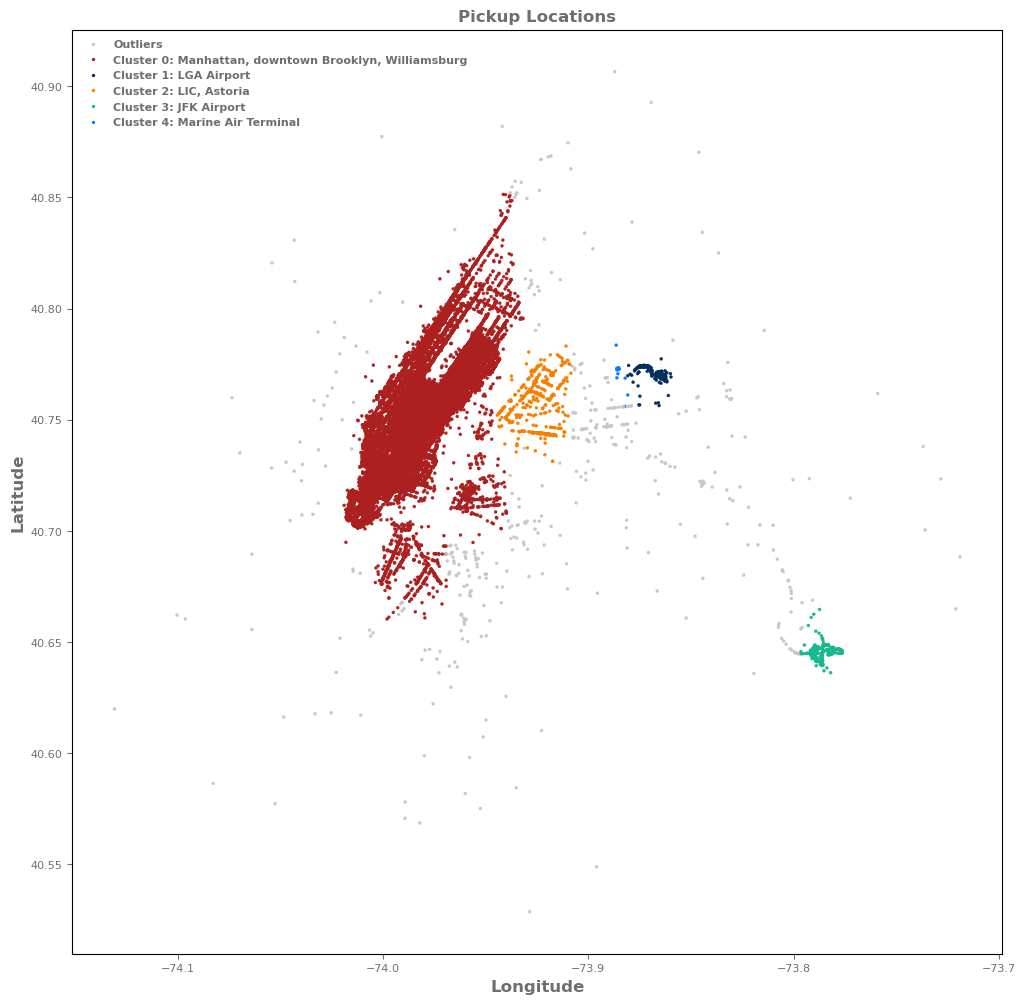

In [2139]:
plt.figure(figsize = (12, 12))

scatter = sns.scatterplot(x = taxi['pickup_longitude'],
                          y = taxi['pickup_latitude'],
                          hue = taxi['pickup_clusters'],
                          palette = color_map,
                          s = 5, 
                          edgecolor = None)

plt.title('Pickup Locations', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
plt.xlabel('Longitude', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
plt.ylabel('Latitude', color = '#6e6e6e', fontsize = 12, fontweight = 'bold');

#--- leveraged chatgpt for this code block -----------------------------------------------------
custom_labels = ['Outliers', 
                 'Cluster 0: Manhattan, downtown Brooklyn, Williamsburg',
                 'Cluster 1: LGA Airport',
                 'Cluster 2: LIC, Astoria',
                 'Cluster 3: JFK Airport',
                 'Cluster 4: Marine Air Terminal'
                ]

handles, _ = scatter.get_legend_handles_labels()

plt.tick_params(axis = 'both', colors = '#6e6e6e', labelsize = 8)

plt.legend(handles = handles, labels = custom_labels, frameon = False, loc = 'upper left', 
           prop = {'size': 8, 'weight': 'bold'}, labelcolor = '#6e6e6e')
#-----------------------------------------------------------------------------------------------

plt.savefig('../images/scatter_pickup_cluster_locations.png');

The concept seems to be working, somewhat. DBSCAN was able to identify some useful clusters, such as rides originating at JFK and LGA airports. That's valuable information. There's also a very odd cluster left of LGA, that based on local knowledge, mainly corresponds to rides that originated at the Marine Air Terminal, which is part of the airport complex. And then there's that geographically large mega cluster that encompasses most of Manhattan, along with areas in Downtown Brooklyn and nearby Williamsburg.<br><br>
In retrospect, based on further reading, I'll return to this section to break down that large cluster into smaller, more significant clusters that better represent specific hubs that I'm trying to isolate, such as Grand Central Station, Penn Station, Wall Street, etc.  Those smaller, more focused clusters may yield good inputs into prediciting the fare - or not.<br><br>
For the sake of keeping the current iteration on track, let's now dummify these clusters to add to the model's features.

In [2147]:
dummy_col_pickups = pd.get_dummies(taxi['pickup_clusters'], prefix = 'p', prefix_sep = '_', drop_first = True, dtype = int)

In [2149]:
dummy_col_pickups.shape

(53351, 5)

In [2151]:
print(f'Before: {taxi.shape}')
taxi = pd.concat([taxi, dummy_col_pickups], axis = 1)
print(f'After: {taxi.shape}')

Before: (53351, 14)
After: (53351, 19)


In [2157]:
# confirm columns
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4'],
      dtype='object')

---
**Updated Linear Model**

In [2163]:
cols_to_drop = ['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'pickup_clusters', 'pickup_clusters_color']

The baseline model's only feature is, thus far, `geodesic_distance`.  For the next iteration, the following features will be added: `p_0` `p_1`, `p_2`, `p_3` and `p_4`, which correspond to the corresponding cluster numbers.

In [2166]:
X2 = taxi.drop(columns = cols_to_drop)
y2 = taxi['fare_amount']

X2.shape, y2.shape

((53351, 6), (53351,))

In [2170]:
# train/test split, default of 75/25
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 1976, stratify = taxi['pickup_clusters'])
# confirm dimensions
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((40013, 6), (13338, 6), (40013,), (13338,))

Due to the outsized influence of cluster 0 (about 95% of rides), it makes a lot of sense to stratify the data based on the clusters distribution.

In [2175]:
# instantiate linear model
lr2 = LinearRegression()

In [2177]:
# fit linear model
lr2.fit(X_train2, y_train2)

LinearRegression()

In [2181]:
metrics.append(lu.model_evaluation(lr2, X_train2, X_test2, y_train2, y_test2))

training r2: 0.819, test r2: 0.823, rmse: 3.836


The improvement in RMSE was only 1.49%, which is a small step in the right direction.  Also, the relative closeness of R2 scores is a good indication that the current iteration of the model should still generalize well to unseen data.

------
**Dropoffs**

Let's conduct the same exercise, with the same approach, using the dropoff coordinates from this dataset.

In [941]:
# D matrix, for dropoff coordinates
# convert coordinates to radians, this is to use geodesic distances
# which are actual distances on earth's surface
# then the metric becomes Haversine distance

D = np.radians(taxi[['dropoff_longitude', 'dropoff_latitude']].values)
D.shape

(53351, 2)

In [633]:
%%time
# this will be time consuming, let's measure it to have an idea for future iterations

results2 = []

# determine best combination
for eps in epsilons:
    for rides in minimum_rides:
        dbs = DBSCAN(
        # using Haversine distance, so it must be converted to radians
        eps = eps * radians_conversion,         
        # only consider clusters based on certain number of pickups within the search radius                 
        min_samples = rides,
        # use Haversine distance, which measures actual distance over earth's surface
        metric = 'haversine',
        n_jobs = -1)

        dbs.fit(D)
        labels = dbs.labels_

        clusters = len(np.unique(labels[labels != -1]))
    
        silhouette = silhouette_score(D, labels, metric='haversine') if clusters > 1 else -1
        
        results2.append(
            {'epsilon': eps, 
             'min_samples': rides, 
             'clusters': clusters, 
             'silhouette_score': silhouette}
        )
    print(f'Epsilon {eps} done.')

Epsilon 0.00072 done.
Epsilon 0.0014399999999999999 done.
Epsilon 0.00216 done.
Epsilon 0.0028799999999999997 done.
Epsilon 0.0036 done.
CPU times: total: 46min 43s
Wall time: 45min 50s


Data tabulation and visualization.

In [713]:
summary_table2 = pd.DataFrame(results2)
summary_table2

,epsilon,min_samples,clusters,silhouette_score
0,0.00072,30,14,-0.445016
1,0.00072,45,9,0.054387
2,0.00072,60,16,-0.468283
3,0.00144,30,22,-0.252421
4,0.00144,45,14,-0.162982
5,0.00144,60,8,-0.141667
6,0.00216,30,11,0.206948
7,0.00216,45,13,0.018075
8,0.00216,60,9,0.014328
9,0.00288,30,7,0.639085


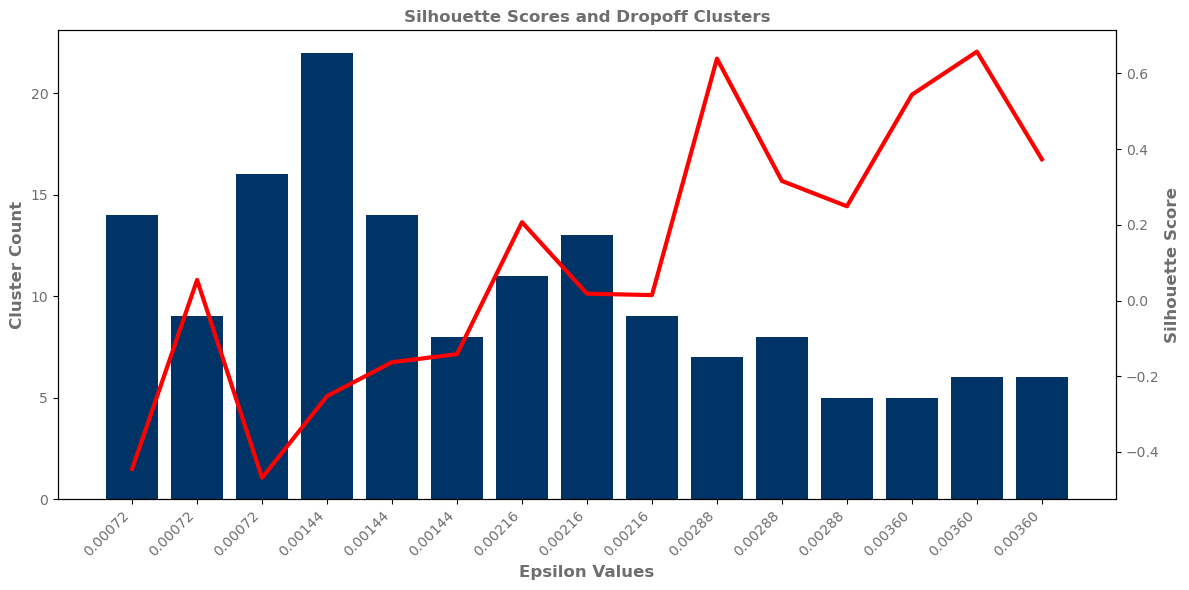

In [2203]:
# plot silhouette scores and clusters

fig, ax1 = plt.subplots(figsize = (12, 6))

ax1.bar(summary_table2.index, summary_table2['clusters'], color = '#003366', label = 'Clusters')
ax1.set_xlabel('Epsilon Values', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax1.set_ylabel('Cluster Count', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax1.tick_params(axis = 'both', labelcolor = '#6e6e6e')
epsilon_values = summary_table2['epsilon'].values

# used chatgpt for these two lines-------------------------------------------------------------------
ax1.set_xticks(range(len(epsilon_values)))
ax1.set_xticklabels([f"{eps:.5f}" for eps in epsilon_values], rotation = 45, ha = 'right', fontsize = 10)
#----------------------------------------------------------------------------------------------------

ax2 = ax1.twinx()
ax2.plot(summary_table2['silhouette_score'], color = '#ff0000', linewidth = 3, label = 'Silhouette Scores')
ax2.set_ylabel('Silhouette Score', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax2.tick_params(axis = 'both', labelcolor = '#6e6e6e')

plt.title('Silhouette Scores and Dropoff Clusters', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')

plt.tight_layout();

plt.savefig('../images/silhouette_scores_dropoff_clusters.png')

Based on silhouette score alone, it makes sense to also use a clustering algorithm that takes into account 5 blocks, but this time, at least 45 rides to form a cluster.

In [2206]:
# replicate DBS with eps=0.00360 (5 blocks), mininum rides = 45
dbs2 = DBSCAN(eps = 0.00360 * radians_conversion, 
             min_samples = 45, 
             metric = 'haversine')

In [2208]:
dbs2.fit(D)

DBSCAN(eps=6.283185307179586e-05, metric='haversine', min_samples=45)

In [643]:
round(silhouette_score(D, dbs2.labels_, metric = 'haversine'), 3)

0.658

In [2210]:
# add dropoff clusters column
taxi['dropoff_clusters'] = dbs2.labels_

In [2212]:
# check counts
taxi['dropoff_clusters'].value_counts(normalize = True)

dropoff_clusters
 0    0.949017
-1    0.027291
 1    0.012821
 2    0.006485
 4    0.002343
 3    0.001162
 5    0.000881
Name: proportion, dtype: float64

Although there is an extra cluster on the dropoff side, there's still one super large cluster that gobbles up 95% of observations.  The visualization may be similar to the pickups.

In [2215]:
taxi['dropoff_clusters_color'] = taxi['dropoff_clusters'].map(color_map)

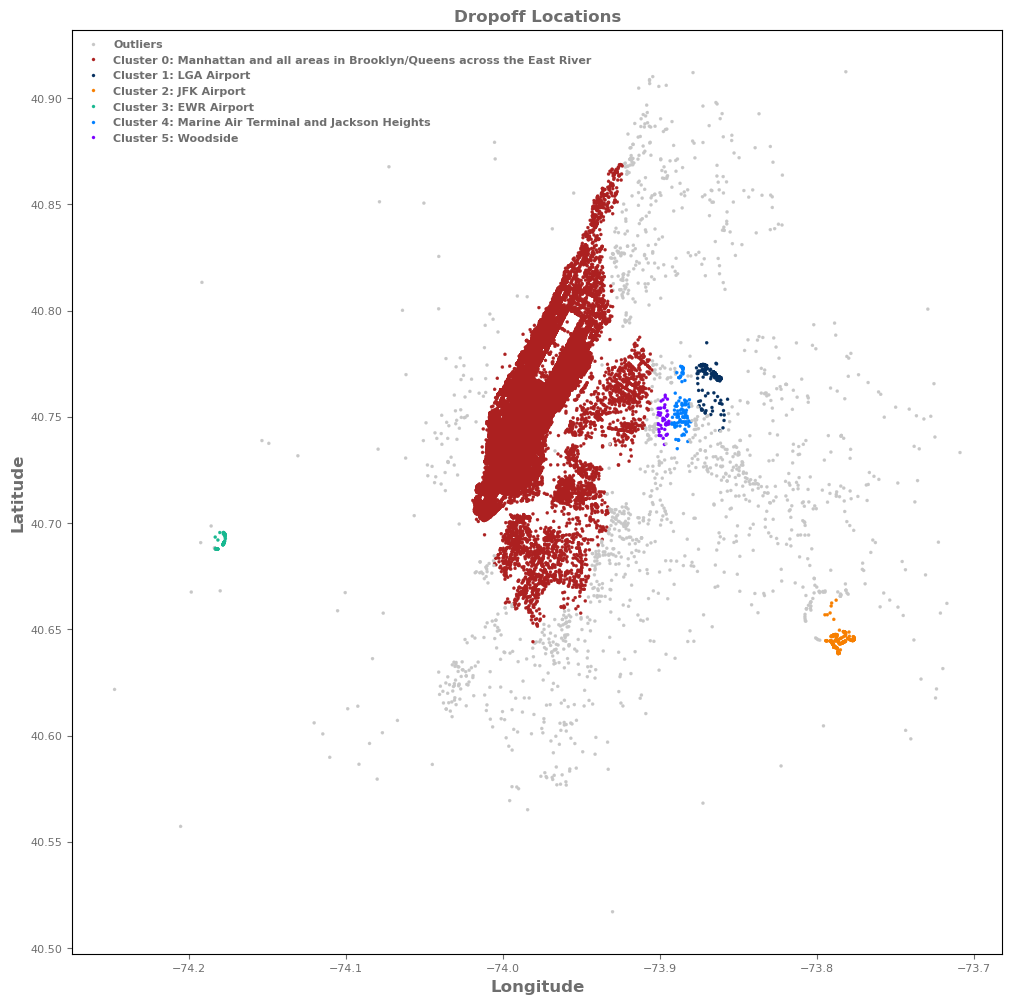

In [2224]:
plt.figure(figsize = (12, 12))

scatter = sns.scatterplot(x = taxi['dropoff_longitude'],
                          y = taxi['dropoff_latitude'],
                          hue = taxi['dropoff_clusters'],
                          palette = color_map,
                          s = 5, 
                          edgecolor = None)

plt.title('Dropoff Locations', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
plt.xlabel('Longitude', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
plt.ylabel('Latitude', color = '#6e6e6e', fontsize = 12, fontweight = 'bold');

#--- leveraged chatgpt for this code block -----------------------------------------------------
custom_labels = ['Outliers', 
                 'Cluster 0: Manhattan and all areas in Brooklyn/Queens across the East River',
                 'Cluster 1: LGA Airport',
                 'Cluster 2: JFK Airport',
                 'Cluster 3: EWR Airport',
                 'Cluster 4: Marine Air Terminal and Jackson Heights',
                 'Cluster 5: Woodside'
                ]

handles, _ = scatter.get_legend_handles_labels()

plt.tick_params(axis = 'both', colors = '#6e6e6e', labelsize = 8)

plt.legend(handles = handles, labels = custom_labels, frameon = False, loc = 'upper left', 
           prop = {'size': 8, 'weight': 'bold'}, labelcolor = '#6e6e6e')
#-----------------------------------------------------------------------------------------------

plt.savefig('../images/scatter_dropoff_cluster_locations.png');

The geographical dispersion of the dropoff points is similar to that of the pickup points, with three notable exceptions. The mega cluster is bigger, there's a new cluster centered around Woodside, and there's a new cluster at EWR airport.<br><br>
For the sake of this iteration, we'll follow the same strategy as the pickup points, and dummify these clusters to add as features to the model. It is recommended, post project, to look into creating more, smaller, localized clusters.

In [2243]:
dummy_col_dropoffs = pd.get_dummies(taxi['dropoff_clusters'], prefix = 'd', prefix_sep = '_', drop_first = True, dtype = int)

In [2245]:
dummy_col_dropoffs.shape

(53351, 6)

In [2247]:
print(f'Before: {taxi.shape}')
taxi = pd.concat([taxi, dummy_col_dropoffs], axis = 1)
print(f'After: {taxi.shape}')

Before: (53351, 21)
After: (53351, 27)


In [2249]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'd_5'],
      dtype='object')

In [2251]:
# update columns to drop list
cols_to_drop.append('dropoff_clusters')
cols_to_drop.append('dropoff_clusters_color')

**Updated Linear Model Part 2**

Add dummified dropoff cluster columns as features into model.

In [2254]:
X3 = taxi.drop(columns = cols_to_drop)
y3 = taxi['fare_amount']

X3.shape, y3.shape

((53351, 12), (53351,))

In [2258]:
# train/test split, default of 75/25
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state = 1976, stratify = taxi['pickup_clusters'])
# confirm dimensions
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((40013, 12), (13338, 12), (40013,), (13338,))

Same as before, due to the outsized influence of cluster 0 (about 95% of rides), it makes a lot of sense to continue stratifying the data based on the clusters distribution. Stratifying by `dropoff_clusters` was already tried, the model performs better if the stratification is based on `pickup_clusters`.

In [2260]:
# instantiate new linear model
lr3 = LinearRegression()

In [2262]:
# fit  new linear model
lr3.fit(X_train3, y_train3)

LinearRegression()

In [2268]:
metrics.append(lu.model_evaluation(lr3, X_train3, X_test3, y_train3, y_test3))

training r2: 0.836, test r2: 0.837, rmse: 3.691


The improvement in RSME relative to the previous model is 3.77%, and relative to the baseline model it is 5.21%.  On top of that, the R2 scores between the training set and test set are still within close proximity, so not only is the model gaining predictive power, it should also generalize well to unseen data.  This is good progress.

----
#### **Feature Engineering**

---
**Estimated Distance**

Distance is the dominant feature, specifically, `geodesic_distance`. Which, once again, it's a straight distance along the earth's surface between two points (pickup and dropoff coordinates).  In reality, though, driving distances are longer due to many factors like street layouts, natural barriers, etc. At NYC's latitude, and taking the Manhattan grid into account, once geodesic distances exceed 10km (6.2 miles) the gap between geodesic and actual distance begins to increase a lot.  So, in order to take this into account, a new column (`estimated_distance`), needs to be created.  For the sake of simplicity on this iteration, we'll just multiply geodesic distance by a factor of 1.15 if it's less than 10km, and by a factor of 1.2 if it's 10km or greater.

In [2276]:
taxi['estimated_distance'] = taxi['geodesic_distance'].map(lambda x: x*1.15 if x < 10 else x*1.2)

In [2278]:
# confirm
taxi[taxi['geodesic_distance'] > 9][['geodesic_distance', 'estimated_distance']].head()

,geodesic_distance,estimated_distance
key,,
2009-01-02 19:38:09.000000200,9.460427,10.879491
2009-01-02 21:44:00.000000630,14.917676,17.901212
2009-01-03 04:06:35.000000100,9.649887,11.097370
2009-01-03 21:34:17.000000500,13.954507,16.745408
2009-01-04 00:28:00.000000610,11.871535,14.245842


Check now if the correlations change significanly or not.

In [2281]:
print(round(taxi['geodesic_distance'].corr(taxi['fare_amount']), 5))
print(round(taxi['estimated_distance'].corr(taxi['fare_amount']), 5))

0.90267
0.90256


Although the correlation for estimated distance is negligibly smaller, I'm keeping this one in favor of geodesic distance because it better approximates reality.

In [2284]:
# update columns to drop, swap geodesic distance for estimated distance 
# in the next model iteration
cols_to_drop.append('geodesic_distance')

In [2286]:
X4 = taxi.drop(columns = cols_to_drop)
y4 = taxi['fare_amount']
# confirm we have the right features
X4.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance'],
      dtype='object')

In [2292]:
# train/test split, default of 75/25
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, random_state = 1976, stratify = taxi['pickup_clusters'])
# confirm dimensions
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((40013, 12), (13338, 12), (40013,), (13338,))

And once again, same as before, due to the outsized influence of cluster 0 (about 95% of rides), it makes a lot of sense to continue stratifying the data based on the clusters distribution. Stratifying by `dropoff_clusters` was already tried, the model performs better if the stratification is based on `pickup_clusters`.

In [2294]:
# instantiate new linear model
lr4 = LinearRegression()
# fit new linear model
lr4.fit(X_train4, y_train4)

LinearRegression()

In [2298]:
metrics.append(lu.model_evaluation(lr4, X_train4, X_test4, y_train4, y_test4))

training r2: 0.835, test r2: 0.836, rmse: 3.698


There is a minor drop in RMSE (0.19%) for this model compared to the previous version.  However, relative to the baseline model, the overall improvement in RMSE is still 5.03%.  It is also worth noting that the R2 scores continue to indicate that the model should generalize well to unseen data due to the minuscule gap between the two figures.

----
**Interaction: Distance x Hour**

Based on the EDA exercise, it was noted that there might be hidden relationships between distances and the hour of the day. Therefore, an interactive term was engineered to take this into account.

In [2305]:
# if hour is equal to zero, multipy by 1
# else, multiply by hour

taxi['distance_hour'] = taxi.apply(lambda row: row['estimated_distance'] if row['hour'] == 0
                                   else row['estimated_distance'] * row['hour'],
                                   axis = 1)
# confirm
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'd_5', 'estimated_distance', 'distance_hour'],
      dtype='object')

In [2307]:
# verify
taxi[['hour', 'estimated_distance', 'distance_hour']].head()

,hour,estimated_distance,distance_hour
key,,,
2009-01-01 00:48:11.000000200,0,5.196234,5.196234
2009-01-01 00:54:13.000000100,0,5.135030,5.135030
2009-01-01 01:07:13.000000100,1,1.451833,1.451833
2009-01-01 01:12:02.000000100,1,4.061769,4.061769
2009-01-01 04:34:56.000000100,4,1.855340,7.421362


No new features to drop. Fit the next model, continue stratifying the data by `pickup_clusters`.

In [2310]:
X5 = taxi.drop(columns = cols_to_drop)
y5 = taxi['fare_amount']
# confirm features
X5.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour'],
      dtype='object')

In [2312]:
# train/test split, default of 75/25
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, random_state = 1976, stratify = taxi['pickup_clusters'])
# confirm dimensions
X_train5.shape, X_test5.shape, y_train5.shape, y_test5.shape

((40013, 13), (13338, 13), (40013,), (13338,))

In [2315]:
# instantiate new linear model
lr5 = LinearRegression()
# fit new linear model
lr5.fit(X_train5, y_train5)

LinearRegression()

In [2319]:
metrics.append(lu.model_evaluation(lr5, X_train5, X_test5, y_train5, y_test5))

training r2: 0.836, test r2: 0.836, rmse: 3.699


Interestingly, performance remained flat.  There is a negligible drop in RMSE, but at the same time a negligible improvement in R2 scores.

----
**Airport Rides**

Yellow cab fares in NYC have special rules for airport rides.  Rides from JFK into Manhattan charge a flat rate.  Rides to and from LGA/Manhattan incur a surcharge.  Rides to EWR also incur a different surcharge.  Since we know which clusters belong to the three airports, let's identify those rides and assign an ID to them in a new column called `airport_ride`.  For the sake of simplicity on this iteration, an airport ride is any ride that either starts at or ends at the airport.

In [2324]:
# function to accomplish this task
def is_airport(row):
    '''
    This function identifies rides that begin or end at the airport.

    Parameters: integer, row: The cluster label at each row.

    Returns: string, which correspond to the airport code for the given cluster.
    '''
    
    if row['pickup_clusters'] == 1 or row['dropoff_clusters'] == 1:
        return 'LGA'
    elif row['pickup_clusters'] == 3 or row['dropoff_clusters'] == 2:
        return 'JFK'
    elif row['dropoff_clusters'] == 3:
        return 'EWR'
    else:
        return None

In [2326]:
# apply to df and create column
taxi['airport_ride'] = taxi.apply(is_airport, axis = 1)

In [2328]:
# check counts
taxi['airport_ride'].value_counts(dropna = False)

airport_ride
None    50616
LGA      1585
JFK      1089
EWR        61
Name: count, dtype: int64

Airport rides have been successfully segregated, now let's dummify the three airports into their own columns.

In [2331]:
# dummify airport_ride
dummy_col_airport = pd.get_dummies(taxi['airport_ride'], drop_first = True, dtype = int)
dummy_col_airport.shape

(53351, 2)

In [2333]:
print(f'Before: {taxi.shape}')
taxi = pd.concat([taxi, dummy_col_airport], axis = 1)
print(f'After: {taxi.shape}')

Before: (53351, 30)
After: (53351, 32)


In [2335]:
# confirm columns
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'd_5', 'estimated_distance', 'distance_hour',
       'airport_ride', 'JFK', 'LGA'],
      dtype='object')

In [2337]:
# update columns to drop, keep only desired features: JFK and LGA
cols_to_drop.append('airport_ride')

In [2339]:
X6 = taxi.drop(columns = cols_to_drop)
y6 = taxi['fare_amount']
# confirm features
X6.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA'],
      dtype='object')

In [2342]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, random_state = 1976, stratify = taxi['pickup_clusters'])
# confirm dimensions
X_train6.shape, X_test6.shape, y_train6.shape, y_test6.shape

((40013, 15), (13338, 15), (40013,), (13338,))

Various stratification strategies were tested for this split, `pickup_clusters` still provide the best performance.

In [2344]:
# instantiate new linear model
lr6 = LinearRegression()
# fit new linear model
lr6.fit(X_train6, y_train6)

LinearRegression()

In [2348]:
metrics.append(lu.model_evaluation(lr6, X_train6, X_test6, y_train6, y_test6))

training r2: 0.837, test r2: 0.837, rmse: 3.683


Only a tiny improvement in RMSE was achieved at 0.43% compared to the previous model.  Relative to the baseline model, though, the overall improvement is 5.42%, so steady progress is being made.  Again, the R2 scores this time are identical within three decimal places, so the model should not be overfit.

---
**Peak Rides**

Also during EDA, some insights were observed regarding rides at certain times of the day on weekdays. Specifically during the so-called peak hours, which in NYC are from 6:30am to 9:30am and then again between 3:00pm and 8:00pm.  A new feature (`peak_rides`) can be engineered from these rides to take into account those hidden relationships.

In [2360]:
# create new column with all zeros
taxi['peak_rides'] = 0
# confirm
taxi['peak_rides'].head()

key
2009-01-01 00:48:11.000000200    0
2009-01-01 00:54:13.000000100    0
2009-01-01 01:07:13.000000100    0
2009-01-01 01:12:02.000000100    0
2009-01-01 04:34:56.000000100    0
Name: peak_rides, dtype: int64

First, identify any row that meets the peak hours conditions. Then, assign 1 to all those rows, leave the rest as zero.

In [2363]:
# this crazy logic required chatgpt intervention 
# what I was creating on my own got too convoluted too quickly

# filter for weekdays (not saturday or sunday)
weekday_condition = ~taxi['day_of_week'].isin(['Saturday', 'Sunday'])

# filter for the morning rush hour (6:30 AM to 9:30 AM)
morning_condition = (taxi['hour'] >= 6) & (taxi['hour'] <= 9) & ((taxi['hour'] != 6) | (taxi['minute'] >= 30)) & ((taxi['hour'] != 9) | (taxi['minute'] <= 30))

# filter for the afternoon/evening rush hour (3:00 PM to 8:00 PM)
afternoon_condition = (taxi['hour'] >= 15) & (taxi['hour'] <= 20)

In [2367]:
# make assignment, change to 1
indexes = taxi[weekday_condition & (morning_condition | afternoon_condition)].index
taxi.loc[indexes, 'peak_rides'] = 1

In [2369]:
# confirm counts
taxi['peak_rides'].value_counts()

peak_rides
0    35151
1    18200
Name: count, dtype: int64

Incorporate new feature into next model iteration.

In [2372]:
X7 = taxi.drop(columns = cols_to_drop)
y7 = taxi['fare_amount']
# confirm features
X7.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA',
       'peak_rides'],
      dtype='object')

In [2414]:
# train/test split, keep default of 75/25
X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, random_state = 1976, stratify = taxi['peak_rides'])
# confirm dimensions
X_train7.shape, X_test7.shape, y_train7.shape, y_test7.shape

((40013, 16), (13338, 16), (40013,), (13338,))

On this occasion, the stratification was changed to `peak_rides`, of all the strategies that were tested, this one yielded the best performance.

In [2377]:
# instantiate new model
lr7 = LinearRegression()
# fit new model
lr7.fit(X_train7, y_train7)

LinearRegression()

In [2391]:
metrics.append(lu.model_evaluation(lr7, X_train7, X_test7, y_train7, y_test7))

training r2: 0.835, test r2: 0.845, rmse: 3.654


Another slight improvement in RMSE. This time the increase, relative to the previous model, was 0.79%.  Compared to the baseline model, the overall RMSE improvement is so far 6.16%.  The R2 testing score is slightly higher than the training score but only 1/100th of a point.  Nothing crazy.  The model should still be generalizing well to unseen data.

----
**Weekend Rides**

Another observation from the EDA exercise was the noticeable changes on weekends, specially on Sundays, which had the second least number of rides, but the longest average distances traveled, as well as the second highest average fares.  In order to capture those relationships, another feature will be engineered to take those rides into account: `weekend_rides`.

In [2401]:
# create new column with all zeros
taxi['weekend_rides'] = 0

In [2403]:
# identify weekend rides
weekend_condition = taxi['day_of_week'].isin(['Saturday', 'Sunday'])

In [2405]:
# assign 1 to all rows that are weekend rides
indexes = taxi[weekend_condition].index
taxi.loc[indexes, 'weekend_rides'] = 1

In [2407]:
# confirm count
taxi['weekend_rides'].value_counts()

weekend_rides
0    38290
1    15061
Name: count, dtype: int64

Incorporate new feature into next model iteration.

In [2410]:
X8 = taxi.drop(columns = cols_to_drop)
y8 = taxi['fare_amount']
# confirm features
X8.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides'],
      dtype='object')

In [2416]:
# train/test split, default of 75/25
X_train8, X_test8, y_train8, y_test8 = train_test_split(X8, y8, random_state = 1976, stratify = taxi['peak_rides'])
# confirm dimensions
X_train8.shape, X_test8.shape, y_train8.shape, y_test8.shape

((40013, 17), (13338, 17), (40013,), (13338,))

Also on this occasion, the stratification strategy is still `peak_rides`. All other tested strategies did not yield better results.

In [2418]:
# instantiate new linear model
lr8 = LinearRegression()
# fit new linear model
lr8.fit(X_train8, y_train8)

LinearRegression()

In [2422]:
metrics.append(lu.model_evaluation(lr8, X_train8, X_test8, y_train8, y_test8))

training r2: 0.835, test r2: 0.845, rmse: 3.652


This time the improvement is negligible compared to the previous model. But the overall improvement, relative to the baseline model, is now 6.21%.

-----
**Holiday Rides**

Another interesting dynamic that was observed during the EDA phase was that average fares experience three peaks during the year, one of those peaks takes place around the holidays. In fact, it is the highest peak.  For the sake of simplicity, this model will only look into the holiday peak by engineering a feature that just takes into account rides that took place in either November or December.

In [2434]:
# create new column with all zeros
taxi['holiday_rides'] = 0

In [2436]:
# identify correct rows
holiday_condition = taxi['month'].isin(['November', 'December'])

In [2438]:
# assign 1 to holiday rides, keep the rest as zero
indexes = taxi[holiday_condition].index
taxi.loc[indexes, 'holiday_rides'] = 1

In [2440]:
# confirm counts
taxi['holiday_rides'].value_counts()

holiday_rides
0    44628
1     8723
Name: count, dtype: int64

Now add this new feature to the model.

In [2448]:
X9 = taxi.drop(columns = cols_to_drop)
y9 = taxi['fare_amount']
# confirm features
X9.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides', 'holiday_rides'],
      dtype='object')

In [2450]:
# train/test split, keep default of 75/25
X_train9, X_test9, y_train9, y_test9 = train_test_split(X9, y9, random_state = 1976, stratify = taxi['peak_rides'])
# confirm dimensions
X_train9.shape, X_test9.shape, y_train9.shape, y_test9.shape

((40013, 18), (13338, 18), (40013,), (13338,))

Again, various stratification strategies were tested, the best results were achieved by stratifying by `peak_rides`.

In [2453]:
# instantiate new linear model
lr9 = LinearRegression()
# fit new linear model
lr9.fit(X_train9, y_train9)

LinearRegression()

In [2457]:
metrics.append(lu.model_evaluation(lr9, X_train9, X_test9, y_train9, y_test9))

training r2: 0.835, test r2: 0.846, rmse: 3.65


Tiny RMSE improvement compared to the previous model. Overall improvement relative to the baseline is now up to 6.27%.

----
#### **Feature Selection**

----
**Lasso**

More features could possibly be engineered, but rather than continue going down that path, it is best - at this juncture - to actually see which current features are contributing the most to the model's predictive performance.  Running a `Lasso` regression model may help in that task by regularizing the coefficients.  Based on the results, some features may need to be dropped.

In [2463]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Because a `Lasso` regression needs scaled features, it's best to build a pipeline that takes that into account, and then tests for several values of alpha.

In [2466]:
# build pipeline steps
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('ls', Lasso(random_state = 1976))             
])

In [2468]:
# alpha values to test
params = {
    'ls__alpha': [0.001, 0.01, 0.1, 1, 10]
}

In [2470]:
# build grid search object
ls_gs = GridSearchCV(pipe,
                  param_grid = params,
                  verbose = 1,
                  n_jobs = -1
                 )

In [2472]:
# confirm I still have my current features
X_train9.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides', 'holiday_rides'],
      dtype='object')

In [2474]:
# fit grid search object
ls_gs.fit(X_train9, y_train9)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ls', Lasso(random_state=1976))]),
             n_jobs=-1, param_grid={'ls__alpha': [0.001, 0.01, 0.1, 1, 10]},
             verbose=1)

Let's take a look at the best alpha value.

In [1767]:
ls_gs.best_params_

{'ls__alpha': 0.001}

In [2481]:
metrics.append(lu.model_evaluation(ls_gs, X_train9, X_test9, y_train9, y_test9))

training r2: 0.835, test r2: 0.845, rmse: 3.651


Even after regularizing, the performance is still the same.  However, let's take a look at the coefficients to see if any features may need to be dropped.

In [2486]:
# extract coefficients
coefficients = ls_gs.best_estimator_.named_steps['ls'].coef_
coefficients

array([-2.67565055e-01, -5.55937871e-01, -7.96907682e-03, -1.22790428e+00,
        2.62821187e-01, -3.42867878e-01, -4.98172269e-01, -7.14128880e-01,
        9.35130634e-01,  2.48335788e-03, -6.99924704e-02,  7.25654150e+00,
        2.33149113e-01,  1.58381122e+00,  1.46959648e+00,  5.97048168e-02,
       -1.51391654e-01,  1.64123565e-01])

In [2488]:
# build summary table for better visualization
keys = X_train9.columns
values = [round(i, 2) for i in coefficients]

coefficients_table = dict(zip(keys, values))
pd.Series(coefficients_table)

p_0                  -0.27
p_1                  -0.56
p_2                  -0.01
p_3                  -1.23
p_4                   0.26
d_0                  -0.34
d_1                  -0.50
d_2                  -0.71
d_3                   0.94
d_4                   0.00
d_5                  -0.07
estimated_distance    7.26
distance_hour         0.23
JFK                   1.58
LGA                   1.47
peak_rides            0.06
weekend_rides        -0.15
holiday_rides         0.16
dtype: float64

Some coefficients are very close to zero, it makes sense to drop them as they may not be contributing much to the model.  A simpler model may perform better.  The arbitrary criteria will be to drop any feature whose coefficient is less than the absolute value of 0.1.

In [2491]:
# drop features with very low coefficients (closest to zero)
features_to_keep = list(keys[np.abs(values) >= 0.1])  # <<--- this line of code was result of chatgpt inquiry
print(f'Count: {len(features_to_keep)}')
features_to_keep

Count: 14


['p_0',
 'p_1',
 'p_3',
 'p_4',
 'd_0',
 'd_1',
 'd_2',
 'd_3',
 'estimated_distance',
 'distance_hour',
 'JFK',
 'LGA',
 'weekend_rides',
 'holiday_rides']

Four features were dropped.  Let's run another `Lasso` regression based on the remaining 14 features.

In [2494]:
X10 = taxi[features_to_keep]
y10 = taxi['fare_amount']
# confirm features
X10.columns

Index(['p_0', 'p_1', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3',
       'estimated_distance', 'distance_hour', 'JFK', 'LGA', 'weekend_rides',
       'holiday_rides'],
      dtype='object')

In [2496]:
# train/test split, keep default of 75/25
X_train10, X_test10, y_train10, y_test10 = train_test_split(X10, y10, random_state = 1976, stratify = taxi['peak_rides'])
# confirm dimensions
X_train10.shape, X_test10.shape, y_train10.shape, y_test10.shape

((40013, 14), (13338, 14), (40013,), (13338,))

Surprisingly, even though `peak_rides` was dropped from the model, for some reason it still provides the best results when the data is stratified by the feature.

In [2498]:
# this time test only four alpha values, 10 is too large
params2 = {
    'ls__alpha': [0.001, 0.01, 0.1, 1]
}

In [2500]:
# set up new grid search object
ls2_gs = GridSearchCV(pipe,
                  param_grid = params2,
                  verbose = 1,
                  n_jobs = -1
                 )

In [2502]:
# fit new grid search object with reduced features
ls2_gs.fit(X_train10, y_train10)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ls', Lasso(random_state=1976))]),
             n_jobs=-1, param_grid={'ls__alpha': [0.001, 0.01, 0.1, 1]},
             verbose=1)

Let's check the best alpha value again.

In [2505]:
ls2_gs.best_params_

{'ls__alpha': 0.001}

In [2510]:
metrics.append(lu.model_evaluation(ls2_gs, X_train10, X_test10, y_train10, y_test10))

training r2: 0.835, test r2: 0.845, rmse: 3.653


Also surprising it's the fact that performance worsened, albeit negligibly, after dropping those very low-coefficient features. Let's take a look at the new coefficients for the remaining features.

In [1859]:
coefficients2 = ls2_gs.best_estimator_.named_steps['ls'].coef_
coefficients2

array([-0.25405401, -0.54576857, -1.21621796,  0.26566254, -0.3270776 ,
       -0.48664237, -0.7070065 ,  0.93750628,  7.25460361,  0.2376945 ,
        1.5800302 ,  1.46354187, -0.1783943 ,  0.16420398])

In [1861]:
keys2 = X_train10.columns
values2 = [round(i, 2) for i in coefficients2]

In [1863]:
coefficients_table2 = dict(zip(keys2, values2))
pd.Series(coefficients_table2)

p_0                  -0.25
p_1                  -0.55
p_3                  -1.22
p_4                   0.27
d_0                  -0.33
d_1                  -0.49
d_2                  -0.71
d_3                   0.94
estimated_distance    7.25
distance_hour         0.24
JFK                   1.58
LGA                   1.46
weekend_rides        -0.18
holiday_rides         0.16
dtype: float64

RMSE is not improving, it remains stuck at 3.65. However, these 14 features seem reasonable given their coefficients. For the sake of time and simplicity, let's try the XGBoost regressor as a last resort with only these features.

----
**XGBooster**

In [1193]:
from xgboost import XGBRegressor

In [2516]:
# instantiate XGBregressor
xgb = XGBRegressor(random_state = 1976)

In [2518]:
# parameters to test for
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 1.0]
}

In [2520]:
# instantiate grid search object
xgb_gs = GridSearchCV(
    xgb,
    param_grid = xgb_params,
    n_jobs = -1,
    verbose = 1
)

In [2524]:
%%time
# fit grid search object
xgb_gs.fit(X_train10, y_train10)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
CPU times: total: 1min 53s
Wall time: 10min 23s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=1976, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 200, 300, 400],
                         'subsample': [0.6, 0.7, 0.8, 1.0]},
             verbose=1)

In [2538]:
metrics.append(lu.model_evaluation(xgb_gs, X_train10, X_test10, y_train10, y_test10))

training r2: 0.85, test r2: 0.85, rmse: 3.602


This is the best performance, so far. RMSE improved by  1.32% relative to the previous best model, and by 7.5% relative to the baseline model.  The R2 scores for the training and test sets are identical, which indicates the model should not be overfit, and shoud therefore generalize well to unseen data. For the sake of time, no new model iterations will be attempted.  However, it is recommended, post project, to come back and continue tweaking these models and further optimize performance.<br><br>
Let's visualize the results.

In [2545]:
model_summary = pd.DataFrame(metrics)
model_summary

,train_r2,test_r2,rmse
0,0.812,0.822,3.894
1,0.819,0.823,3.836
2,0.836,0.837,3.691
3,0.835,0.836,3.698
4,0.836,0.836,3.699
5,0.837,0.837,3.683
6,0.835,0.845,3.654
7,0.835,0.845,3.652
8,0.835,0.846,3.650
9,0.835,0.845,3.651


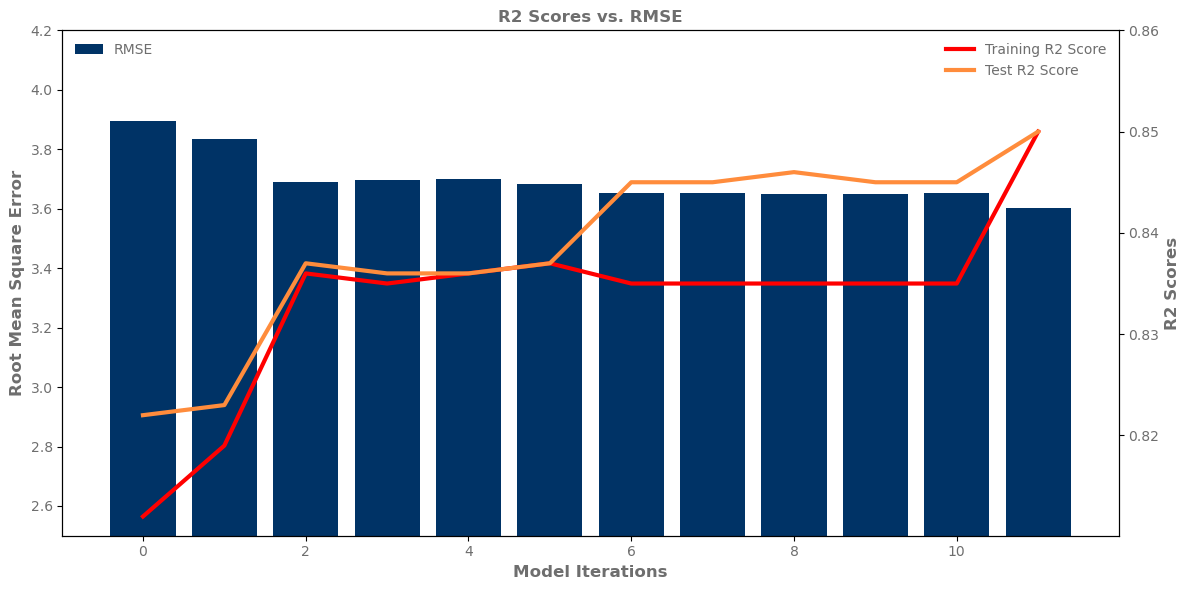

In [2580]:
# plot metrics

fig, ax1 = plt.subplots(figsize = (12, 6))

ax1.bar(model_summary.index, model_summary['rmse'], color = '#003366', label = 'RMSE')
ax1.set_ylim(bottom = 2.5, top = 4.2)
ax1.set_xlabel('Model Iterations', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax1.set_ylabel('Root Mean Square Error', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax1.tick_params(axis = 'both', labelcolor = '#6e6e6e')

ax2 = ax1.twinx()
ax2.plot(model_summary['train_r2'], color = '#ff0000', linewidth = 3, label = 'Training R2 Score')
ax2.plot(model_summary['test_r2'], color = '#ff8c3c', linewidth = 3, label = 'Test R2 Score')
ax2.set_ylim(top = 0.86)
ax2.set_ylabel('R2 Scores', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax2.tick_params(axis = 'both', labelcolor = '#6e6e6e')

plt.title('R2 Scores vs. RMSE', color = '#6e6e6e', fontsize = 12, fontweight = 'bold')
ax1.legend(frameon = False, loc = 'upper left', labelcolor = '#6e6e6e')
ax2.legend(frameon = False, loc = 'upper right', labelcolor = '#6e6e6e')

plt.tight_layout();

plt.savefig('../images/model_metrics.png')

This is an effective visual summary of the various models performance across all iterations.  The last model, based on `XGBRegressor` is by far the best.<br><br>
This is the end of modeling the data.  This can be called version 1.0.  The models are ready to be pickled and saved for use with the streamlit application.

-----
**Save Dataframe & Pickle Models**

In [1879]:
taxi.to_csv('../data/clean_data/taxi_clean_set_v3.csv')

In [2585]:
import pickle

In [1883]:
with open('../models/xgb_model.pkl', 'wb') as x:
  pickle.dump(xgb_gs, x)

In [1885]:
with open('../models/dbs_pickups.pkl', 'wb') as p:
  pickle.dump(dbs1, p)

In [1887]:
with open('../models/dbs_dropoffs.pkl', 'wb') as d:
  pickle.dump(dbs2, d)